# Imports, loading dataset and utility functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cbottle.visualizations import visualize
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import os
import netCDF4 as nc

from grad_check import concat_dataset_and_extract_q_names, get_differences, load_conditioning_sst

In [2]:
# path_to_folder = "inference_output/1971_2020_global_toa_rad_169h"
# path_to_folder = "inference_output/1990_2020_global_toa_rad_169h"
# path_to_folder = "inference_output/2020_north_atlantic_rlut_96h"
# path_to_folder = "inference_output/2020_north_atlantic_rsut_24h_fixed_noise"
# path_to_folder = "inference_output/1-2July2021_TOA_rad_1h"
path_to_folder = "inference_output/jan_feb_2021_toa_radiation"

# check if concatenated dataset exists
if not os.path.exists(os.path.join(path_to_folder, "concatenated_dataset.nc")):
    concatenated_ds, _ = concat_dataset_and_extract_q_names(path_to_folder, additional_vars=['rsut'])
    concatenated_ds.to_netcdf(os.path.join(path_to_folder, "concatenated_dataset.nc"))
else:
    concatenated_ds = xr.open_dataset(os.path.join(path_to_folder, "concatenated_dataset.nc"))

times = pd.to_datetime(concatenated_ds.time.values, unit='s')

Variables in the dataset: ['U1000', 'U850', 'U700', 'U500', 'U300', 'U200', 'U50', 'U10', 'V1000', 'V850', 'V700', 'V500', 'V300', 'V200', 'V50', 'V10', 'T1000', 'T850', 'T700', 'T500', 'T300', 'T200', 'T50', 'T10', 'Z1000', 'Z850', 'Z700', 'Z500', 'Z300', 'Z200', 'Z50', 'Z10', 'tcwv', 'cllvi', 'clivi', 'tas', 'uas', 'vas', 'rlut', 'rsut', 'pres_msl', 'pr', 'rsds', 'sst', 'sic', 'global_TOA_radiation_grad_sst', 'global_TOA_radiation', 'global_TOA_radiation_grad_doy', 'global_TOA_radiation_grad_tod']


In [3]:
def get_symmetric_colorbar_limits(x):
    # Get the 99th percentile to remove outliers
    vmin = np.percentile(x, 0.01)
    vmax = np.percentile(x, 99.99)

    # Set symmetric color limits based on the most extreme value
    if abs(vmin) > abs(vmax):
        vmax = -vmin
    else:
        vmin = -vmax
    return {'vmin': vmin, 'vmax': vmax}

In [4]:
# Enable LaTeX rendering only if matplotlib can actually use LaTeX
def check_latex_available():
    """Test if matplotlib can actually use LaTeX by attempting a simple render."""
    import matplotlib
    
    # Save current backend and rcParams settings
    original_backend = matplotlib.get_backend()
    original_rcParams = plt.rcParams.copy()
    
    try:
        # Use Agg backend to avoid display issues
        test_fig = plt.figure()
        test_ax = test_fig.add_subplot(111)
        # Try to enable LaTeX
        plt.rcParams['text.usetex'] = True
        # Attempt to render simple LaTeX text
        test_ax.text(0.5, 0.5, r'$\alpha$')
        test_fig.canvas.draw()
        plt.close(test_fig)
        # Restore backend and all original settings
        matplotlib.use(original_backend, force=True)
        plt.rcParams.update(original_rcParams)
        return True
    except Exception as e:
        # print(f"LaTeX not available for matplotlib: {e}")
        # Restore backend and all original settings
        matplotlib.use(original_backend, force=True)
        plt.rcParams.update(original_rcParams)
        return False
if check_latex_available():
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (14, 6)
    plt.rcParams['font.size'] = 16
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Computer Modern Roman']
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'
    print("LaTeX rendering enabled.")
else:
    print("LaTeX not available. Using default matplotlib rendering.")

LaTeX rendering enabled.


# Plot sensitivity maps

## Plot the average for every month


=== PLOTTING GRADIENTS FOR Q: global_TOA_radiation ===

--- MONTH 1 ---
  Averaged gradient range: -0.011019 to 0.009368
  Colorbar limits: -0.010748 to 0.010748

--- MONTH 2 ---
  Averaged gradient range: -0.009346 to 0.014062
  Colorbar limits: -0.013664 to 0.013664

--- MONTH 3 ---
No data for month 3, skipping.

--- MONTH 4 ---
No data for month 4, skipping.

--- MONTH 5 ---
No data for month 5, skipping.

--- MONTH 6 ---
No data for month 6, skipping.

--- MONTH 7 ---
No data for month 7, skipping.

--- MONTH 8 ---
No data for month 8, skipping.

--- MONTH 9 ---
No data for month 9, skipping.

--- MONTH 10 ---
No data for month 10, skipping.

--- MONTH 11 ---
No data for month 11, skipping.

--- MONTH 12 ---
No data for month 12, skipping.


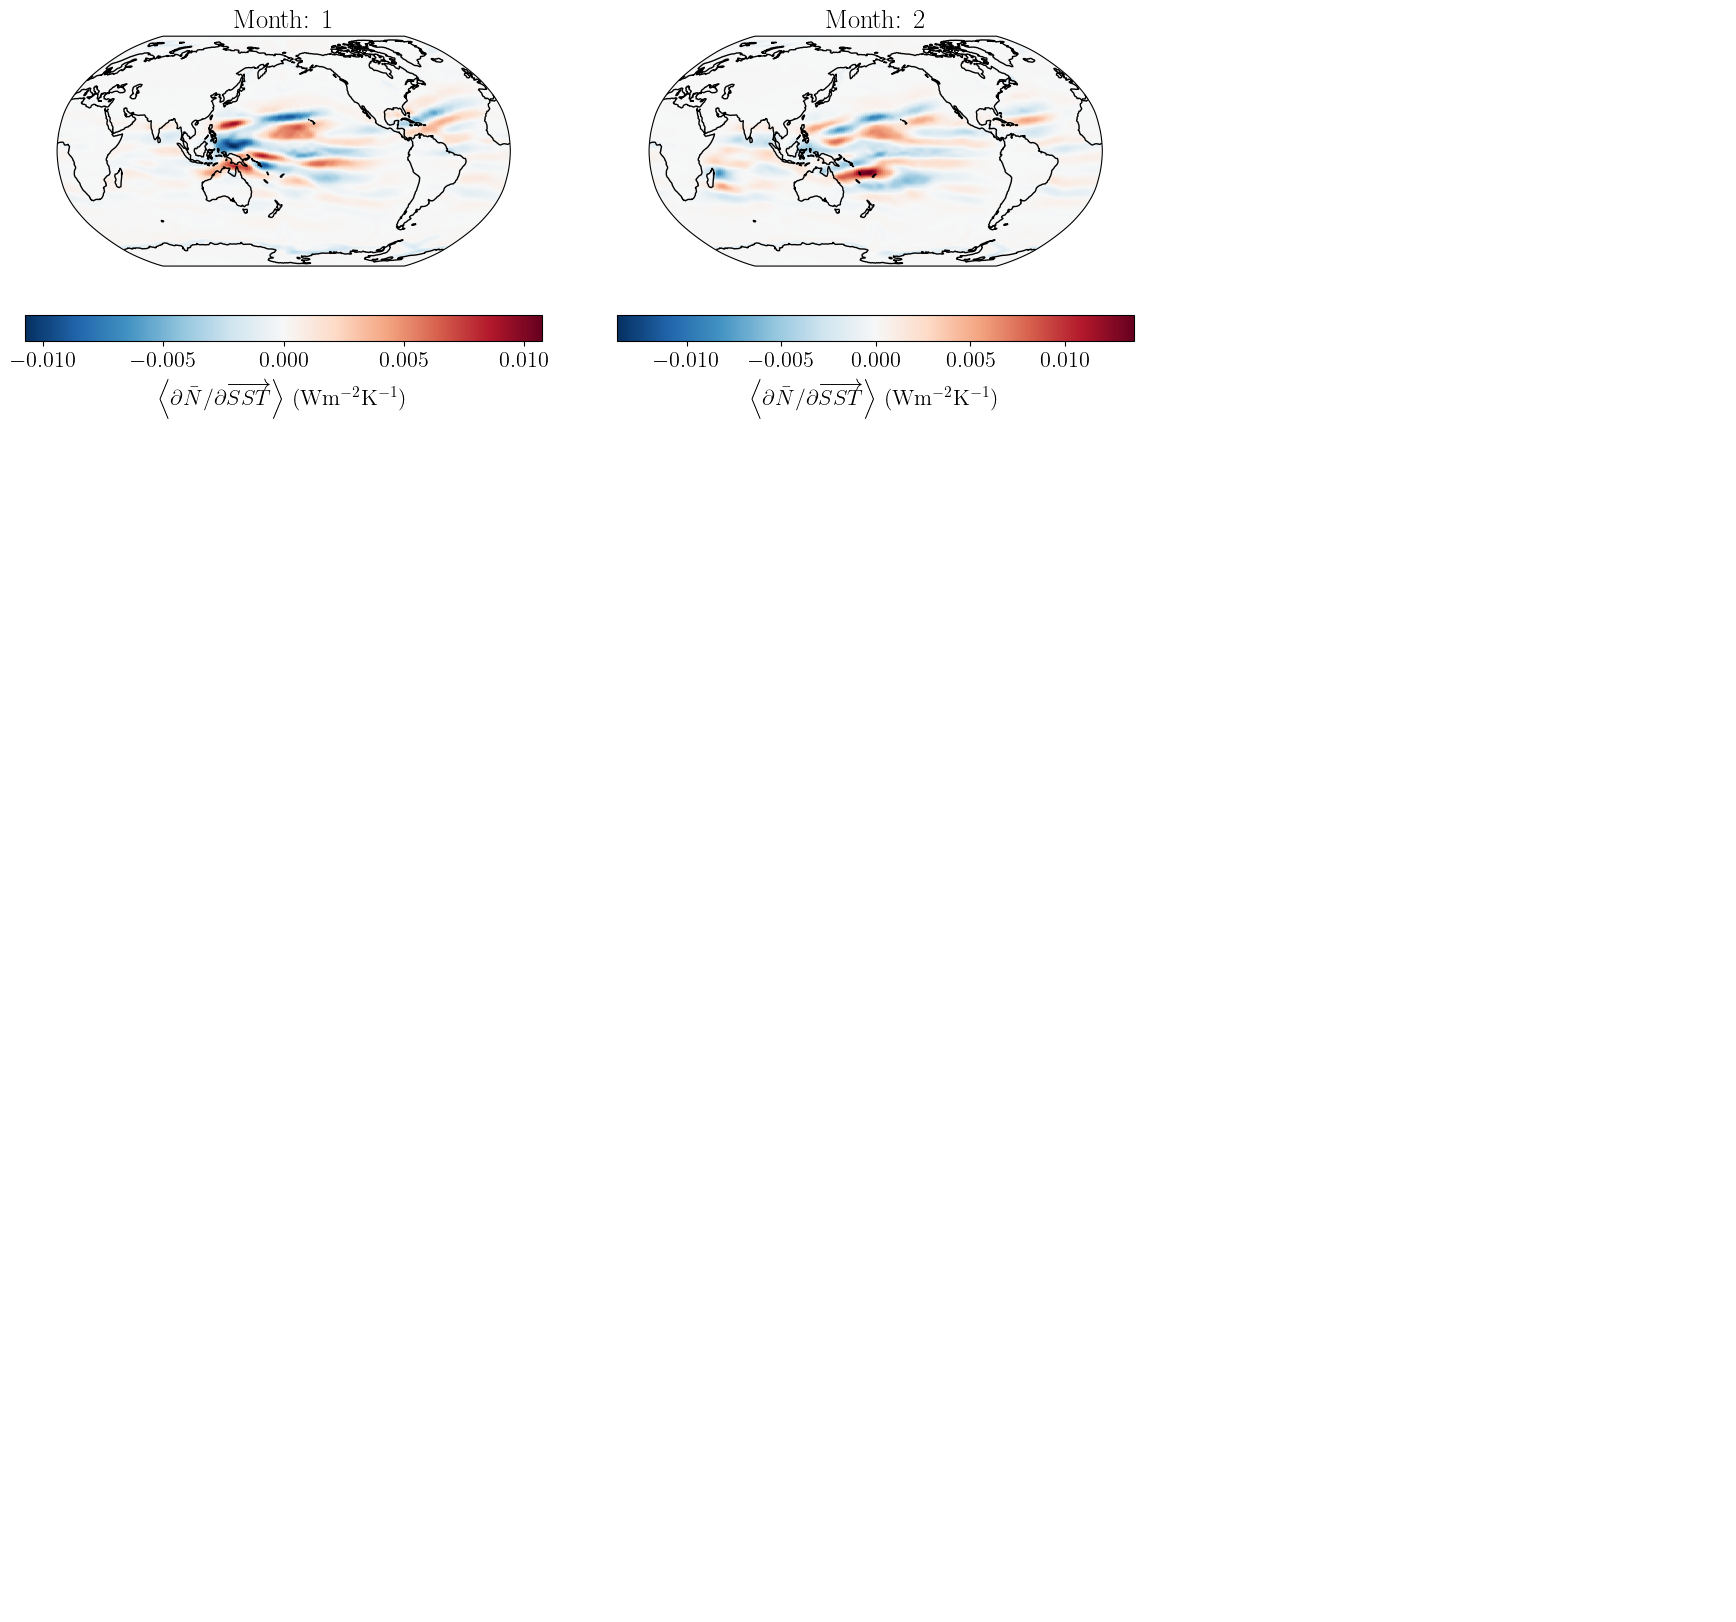

Saved figure to averaged_gradient_plots/0_monthly_jan_feb_2021_toa_radiation.png


In [5]:
q_names_to_plot = [
    "global_TOA_radiation",
    # "north_atlantic_rsut",
]
monthly_grad_data_list = []

# Use 4x3 layout if only one element, otherwise use 12xN layout
if len(q_names_to_plot) == 1:
    nrows, ncols = 4, 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows * 0.7))
    ax = ax.flatten()  # Flatten for easier indexing
else:
    nrows, ncols = 12, len(q_names_to_plot)
    fig, ax = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows * 0.7))
    if ncols == 1:
        ax = ax.reshape(-1, 1)

for i, q_name in enumerate(q_names_to_plot):
    print(f"\n=== PLOTTING GRADIENTS FOR Q: {q_name} ===")
    grad_q_name = [f"{q_name}_grad_sst"]
    # Average the grad_q_name from dataset over each month
    for month in range(1, 13):
        print(f"\n--- MONTH {month} ---")
        # Get indices for this month
        month_indices = [idx for idx, t in enumerate(times) if t.month == month]
        if not month_indices:
            print(f"No data for month {month}, skipping.")
            continue
        
        # Average the gradients for this month
        grad_data_month = concatenated_ds[grad_q_name[0]].isel(time=month_indices).mean(dim='time').values
        monthly_grad_data_list.append(grad_data_month)

        # Get symmetric colorbar limits
        colorbar_limits = get_symmetric_colorbar_limits(grad_data_month)
        
        # Create the title with month information
        title = f"Month: {month}"
        
        print(f"  Averaged gradient range: {grad_data_month.min():.6f} to {grad_data_month.max():.6f}")
        print(f"  Colorbar limits: {colorbar_limits['vmin']:.6f} to {colorbar_limits['vmax']:.6f}")
        
        # Calculate subplot position based on layout
        if len(q_names_to_plot) == 1:
            # For 4x3 layout: row is (month-1)//3, col is (month-1)%3
            subplot_idx = month
        else:
            # For 12xN layout: standard grid position
            subplot_idx = (month - 1) * len(q_names_to_plot) + i + 1
        
        # Create the gradient plot using the visualize function
        result = visualize(
            grad_data_month,  # Averaged gradient data for the month
            region="Robinson_180",  # Use specified projection
            title=title,
            cmap='RdBu_r',
            vmin=colorbar_limits['vmin'],
            vmax=colorbar_limits['vmax'],
            add_colorbar=True,
            colorbar_label=r"$\left<\partial \bar{N}/\partial \overrightarrow{SST}\right>$ (Wm$^{-2}$K$^{-1}$)",
            pos=(nrows, ncols, subplot_idx),  # Grid position
        )

plt.tight_layout()

# remove spine and ticks and numbers
if len(q_names_to_plot) == 1:
    for a in ax:
        for spine in a.spines.values():
            spine.set_visible(False)
        a.tick_params(left=False, bottom=False)
        a.set_xticklabels([])
        a.set_yticklabels([])
else:
    for a in ax.flatten() if hasattr(ax, 'flatten') else ax:
        for spine in a.spines.values():
            spine.set_visible(False)
        a.tick_params(left=False, bottom=False)
        a.set_xticklabels([])
        a.set_yticklabels([])
plt.show()

output_dir = "averaged_gradient_plots"
os.makedirs(output_dir, exist_ok=True)
filename = f"{len(month_indices)}_monthly_{path_to_folder.split('/')[-1]}.png"
filepath = os.path.join(output_dir, filename)
fig.savefig(filepath, dpi=150, bbox_inches='tight')
print(f"Saved figure to {filepath}")
plt.close()


## Plot the averaged sensitivity map for all times

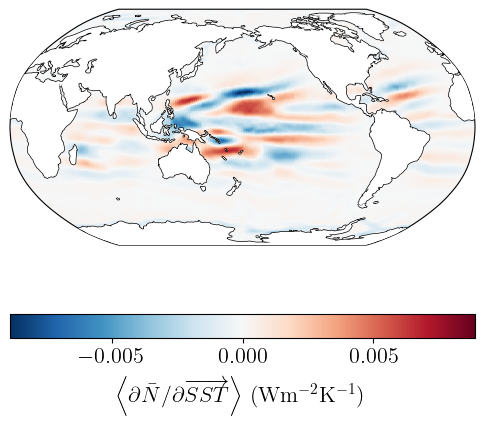

In [6]:
for q_name in q_names_to_plot:
    if "TOA" in q_name:
        colorbar_label = r"$\left<\partial \bar{N}/\partial \overrightarrow{SST}\right>$ (Wm$^{-2}$K$^{-1}$)"
    elif "pr" in q_name:
        colorbar_label = r"$\left<\partial \bar{pr}/\partial \overrightarrow{SST}\right>$ (mm day$^{-1}$ K$^{-1}$)"
    elif "north_atlantic_rlut" == q_name:
        colorbar_label = r"$\left<\partial \bar{R}_{LUT}/\partial \overrightarrow{SST}\right>$ (Wm$^{-2}$K$^{-1}$)"
    else:
        print(f"Unknown q_name {q_name} for setting colorbar label.")
        break

    # Also plot the average of all months together.
    avg_all_months_grad = np.mean(np.array(monthly_grad_data_list), axis=0)
    fig = plt.figure(figsize=(6, 6))

    colorbar_limits = get_symmetric_colorbar_limits(avg_all_months_grad)
    viz_result = visualize(
        avg_all_months_grad,  # Averaged gradient data for all months
        region="Robinson_180",  # Use specified projection
        # title="Average Gradient Across All Months",
        cmap='RdBu_r',
        vmin=colorbar_limits['vmin'],
        vmax=colorbar_limits['vmax'],
        colorbar_label=colorbar_label,
        )
    viz_result.ax.add_feature(cfeature.LAND, zorder=10, facecolor='white')

    plt.savefig(f"{len(times)}_{q_name}_all_months.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
